In [3]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")

True
NVIDIA GeForce RTX 3060 Laptop GPU


In [2]:
# filepath: src/model.py
import pytesseract
import cv2
from utils import extract_text_from_any_file
#to start the virtual environment, run: venv\Scripts\activate 
# Set tesseract path if not in PATH
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

print(extract_text_from_any_file("data/invoice_sample.png"))


invoice

FROM INVOICE # us-001
East Repair Inc. INVOICE DATE 1102/2019
1912 Harvest Lane P.O.# 2312/2019
New York, NY 12210
DUE DATE 26/02/2019
BILL TO SHIP TO
John Smith John Smith
2 Court Square 3787 Pineview Drive
New York, NY 12210 ‘Cambridge, MA 12210
QTY DESCRIPTION UNIT PRICE AMOUNT
1 Front and rear brake cables 100.00 100.00
2 New set of pedal arms 15.00 30.00
3 Labor 3hrs, 5.00 1.00
Subtotal 145.00
Sales Tax 6.25% 9.06

TOTAL $154.06

TERMS & CONDITIONS

Payment is due within 15 days

Please make checks payable to: East Repair Inc.

Swath



# LayoutLMv3 Training Script for Invoice Data Extraction

In [11]:
from datasets import load_dataset
from transformers import LayoutLMv3ForTokenClassification, LayoutLMv3Processor, TrainingArguments, Trainer
import torch

# Load train and validation splits from their respective JSONL files
data_files = {
    "train": "../layoutlmv3_train.jsonl",
    "validation": "../layoutlmv3_valid.jsonl"
}
dataset = load_dataset("json", data_files=data_files)
print(f"Train samples: {len(dataset['train'])}, Validation samples: {len(dataset['validation'])}")

# Build label list from your data
labels = sorted({label for example in dataset['train'] for label in example['labels']})
label2id = {l: i for i, l in enumerate(labels)}
id2label = {i: l for l, i in label2id.items()}

# Load processor and model
processor = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)
model = LayoutLMv3ForTokenClassification.from_pretrained(
    "microsoft/layoutlmv3-base",
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id
)
dataset 

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Train samples: 208, Validation samples: 25


c:\projects\extracteur_de_factures\venv\Lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DatasetDict({
    train: Dataset({
        features: ['file_name', 'tokens', 'bboxes', 'labels'],
        num_rows: 208
    })
    validation: Dataset({
        features: ['file_name', 'tokens', 'bboxes', 'labels'],
        num_rows: 25
    })
})

In [12]:
dataset["train"].features

{'file_name': Value(dtype='string', id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'bboxes': Sequence(feature=Sequence(feature=Value(dtype='int64', id=None), length=-1, id=None), length=-1, id=None),
 'labels': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None)}

In [5]:
import numpy as np
# Preprocessing function for the dataset
def preprocess(example):
    encoding = processor.tokenizer(
        example["tokens"],
        boxes=example["bboxes"],
        truncation=True,
        padding="max_length",
        max_length=512,
        return_tensors="pt"
    )
    encoding = {k: v.squeeze(0) for k, v in encoding.items()}
    # Pad labels to max_length
    labels = [label2id[l] for l in example["labels"]]
    labels = labels + [0] * (512 - len(labels))
    encoding["labels"] = torch.tensor(labels)
    # Print keys for debugging
    print(f"Encoding keys: {list(encoding.keys())}")
    return encoding

# Apply preprocessing
dataset = dataset.map(preprocess, batched=False)
# Print a sample to check keys
print(dataset["train"][0])

Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_ids', 'attention_mask', 'bbox', 'labels']
Encoding keys: ['input_id

In [5]:
# Set format for PyTorch
dataset.set_format(type="torch", columns=["input_ids", "bbox", "attention_mask", "labels"])

In [6]:
# Training arguments
args = TrainingArguments(
    output_dir="./layoutlmv3-invoice",
    per_device_train_batch_size=2,
    num_train_epochs=5,
    logging_steps=10,
    save_steps=100
)

In [7]:
# Trainer setup
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=processor
)

# Start training
trainer.train()

  0%|          | 0/520 [00:00<?, ?it/s]

c:\projects\extracteur_de_factures\venv\Lib\site-packages\transformers\modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'loss': 0.6274, 'grad_norm': 1.3798171281814575, 'learning_rate': 4.9038461538461536e-05, 'epoch': 0.1}
{'loss': 0.118, 'grad_norm': 5.176417827606201, 'learning_rate': 4.8076923076923084e-05, 'epoch': 0.19}
{'loss': 0.0912, 'grad_norm': 1.3457447290420532, 'learning_rate': 4.711538461538462e-05, 'epoch': 0.29}
{'loss': 0.0689, 'grad_norm': 2.2343287467956543, 'learning_rate': 4.615384615384616e-05, 'epoch': 0.38}
{'loss': 0.0698, 'grad_norm': 0.36195263266563416, 'learning_rate': 4.519230769230769e-05, 'epoch': 0.48}
{'loss': 0.0641, 'grad_norm': 2.496365547180176, 'learning_rate': 4.423076923076923e-05, 'epoch': 0.58}
{'loss': 0.0628, 'grad_norm': 0.5372521281242371, 'learning_rate': 4.326923076923077e-05, 'epoch': 0.67}
{'loss': 0.0754, 'grad_norm': 4.295129776000977, 'learning_rate': 4.230769230769231e-05, 'epoch': 0.77}
{'loss': 0.0779, 'grad_norm': 3.2512705326080322, 'learning_rate': 4.134615384615385e-05, 'epoch': 0.87}
{'loss': 0.1358, 'grad_norm': 1.8573956489562988, 'learni

c:\projects\extracteur_de_factures\venv\Lib\site-packages\transformers\modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'loss': 0.0796, 'grad_norm': 1.860960841178894, 'learning_rate': 3.942307692307692e-05, 'epoch': 1.06}
{'loss': 0.0807, 'grad_norm': 2.6580913066864014, 'learning_rate': 3.846153846153846e-05, 'epoch': 1.15}
{'loss': 0.0583, 'grad_norm': 0.9025377631187439, 'learning_rate': 3.7500000000000003e-05, 'epoch': 1.25}
{'loss': 0.0565, 'grad_norm': 0.3094678223133087, 'learning_rate': 3.653846153846154e-05, 'epoch': 1.35}
{'loss': 0.0422, 'grad_norm': 1.097117304801941, 'learning_rate': 3.557692307692308e-05, 'epoch': 1.44}
{'loss': 0.1051, 'grad_norm': 1.9769325256347656, 'learning_rate': 3.461538461538462e-05, 'epoch': 1.54}
{'loss': 0.0608, 'grad_norm': 0.91478031873703, 'learning_rate': 3.365384615384616e-05, 'epoch': 1.63}
{'loss': 0.0571, 'grad_norm': 0.39643773436546326, 'learning_rate': 3.269230769230769e-05, 'epoch': 1.73}
{'loss': 0.0653, 'grad_norm': 0.7996852397918701, 'learning_rate': 3.1730769230769234e-05, 'epoch': 1.83}
{'loss': 0.0613, 'grad_norm': 0.5491281747817993, 'learn

c:\projects\extracteur_de_factures\venv\Lib\site-packages\transformers\modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'loss': 0.0666, 'grad_norm': 0.45093315839767456, 'learning_rate': 2.9807692307692308e-05, 'epoch': 2.02}
{'loss': 0.0353, 'grad_norm': 0.33202746510505676, 'learning_rate': 2.8846153846153845e-05, 'epoch': 2.12}
{'loss': 0.047, 'grad_norm': 1.8834012746810913, 'learning_rate': 2.7884615384615386e-05, 'epoch': 2.21}
{'loss': 0.0612, 'grad_norm': 0.9323872923851013, 'learning_rate': 2.6923076923076923e-05, 'epoch': 2.31}
{'loss': 0.0531, 'grad_norm': 0.7258318662643433, 'learning_rate': 2.5961538461538464e-05, 'epoch': 2.4}
{'loss': 0.0421, 'grad_norm': 0.4541639983654022, 'learning_rate': 2.5e-05, 'epoch': 2.5}
{'loss': 0.0481, 'grad_norm': 0.3175010085105896, 'learning_rate': 2.4038461538461542e-05, 'epoch': 2.6}
{'loss': 0.0516, 'grad_norm': 1.1780999898910522, 'learning_rate': 2.307692307692308e-05, 'epoch': 2.69}
{'loss': 0.0456, 'grad_norm': 0.7545303106307983, 'learning_rate': 2.2115384615384616e-05, 'epoch': 2.79}
{'loss': 0.054, 'grad_norm': 1.5870985984802246, 'learning_rate'

c:\projects\extracteur_de_factures\venv\Lib\site-packages\transformers\modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'loss': 0.0452, 'grad_norm': 0.6881502866744995, 'learning_rate': 2.0192307692307694e-05, 'epoch': 2.98}
{'loss': 0.0449, 'grad_norm': 0.42237433791160583, 'learning_rate': 1.923076923076923e-05, 'epoch': 3.08}
{'loss': 0.0357, 'grad_norm': 1.45503830909729, 'learning_rate': 1.826923076923077e-05, 'epoch': 3.17}
{'loss': 0.0428, 'grad_norm': 0.9592388868331909, 'learning_rate': 1.730769230769231e-05, 'epoch': 3.27}
{'loss': 0.049, 'grad_norm': 0.303587406873703, 'learning_rate': 1.6346153846153847e-05, 'epoch': 3.37}
{'loss': 0.0369, 'grad_norm': 1.480893611907959, 'learning_rate': 1.5384615384615387e-05, 'epoch': 3.46}
{'loss': 0.0494, 'grad_norm': 0.8509019613265991, 'learning_rate': 1.4423076923076923e-05, 'epoch': 3.56}
{'loss': 0.0392, 'grad_norm': 0.4304288327693939, 'learning_rate': 1.3461538461538462e-05, 'epoch': 3.65}
{'loss': 0.0405, 'grad_norm': 0.35078999400138855, 'learning_rate': 1.25e-05, 'epoch': 3.75}
{'loss': 0.0386, 'grad_norm': 1.6064517498016357, 'learning_rate':

c:\projects\extracteur_de_factures\venv\Lib\site-packages\transformers\modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'loss': 0.0346, 'grad_norm': 0.23554609715938568, 'learning_rate': 1.0576923076923077e-05, 'epoch': 3.94}
{'loss': 0.0435, 'grad_norm': 1.6082429885864258, 'learning_rate': 9.615384615384616e-06, 'epoch': 4.04}
{'loss': 0.0427, 'grad_norm': 1.027858853340149, 'learning_rate': 8.653846153846155e-06, 'epoch': 4.13}
{'loss': 0.0422, 'grad_norm': 0.3919295370578766, 'learning_rate': 7.692307692307694e-06, 'epoch': 4.23}
{'loss': 0.0328, 'grad_norm': 0.18003244698047638, 'learning_rate': 6.730769230769231e-06, 'epoch': 4.33}
{'loss': 0.0333, 'grad_norm': 0.10969220101833344, 'learning_rate': 5.76923076923077e-06, 'epoch': 4.42}
{'loss': 0.0297, 'grad_norm': 0.2585669159889221, 'learning_rate': 4.807692307692308e-06, 'epoch': 4.52}
{'loss': 0.0298, 'grad_norm': 0.1357308328151703, 'learning_rate': 3.846153846153847e-06, 'epoch': 4.62}
{'loss': 0.0336, 'grad_norm': 0.46802976727485657, 'learning_rate': 2.884615384615385e-06, 'epoch': 4.71}
{'loss': 0.0353, 'grad_norm': 0.582008421421051, 'le

c:\projects\extracteur_de_factures\venv\Lib\site-packages\transformers\modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


{'loss': 0.0351, 'grad_norm': 1.4467267990112305, 'learning_rate': 9.615384615384617e-07, 'epoch': 4.9}
{'loss': 0.0317, 'grad_norm': 1.0997353792190552, 'learning_rate': 0.0, 'epoch': 5.0}
{'train_runtime': 299.4005, 'train_samples_per_second': 3.474, 'train_steps_per_second': 1.737, 'train_loss': 0.06556579338816496, 'epoch': 5.0}


TrainOutput(global_step=520, training_loss=0.06556579338816496, metrics={'train_runtime': 299.4005, 'train_samples_per_second': 3.474, 'train_steps_per_second': 1.737, 'total_flos': 274149556961280.0, 'train_loss': 0.06556579338816496, 'epoch': 5.0})

In [7]:
from datasets import load_metric

# Define compute_metrics for sequence labeling (BIO tagging)
metric = load_metric("seqeval")

label_list = labels  # already sorted and used for label2id/id2label

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)
    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[pred] for (pred, lab) in zip(prediction, label) if lab != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[lab] for (pred, lab) in zip(prediction, label) if lab != -100]
        for prediction, label in zip(predictions, labels)
    ]
    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"]
    }

# Recreate the Trainer with compute_metrics
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    tokenizer=processor,
    compute_metrics=compute_metrics
)

# Evaluate the model on the validation set and print metrics
results = trainer.evaluate(eval_dataset=dataset["validation"])
print("Validation metrics:")
for k, v in results.items():
    if isinstance(v, float):
        print(f"{k}: {v:.4f}")
    else:
        print(f"{k}: {v}")

# Optionally, show a few predictions vs. ground truth for manual inspection

c:\projects\extracteur_de_factures\venv\Lib\site-packages\datasets\load.py:759: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(
c:\projects\extracteur_de_factures\venv\Lib\site-packages\transformers\modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
c:\projects\extracteur_de_factures\venv\Lib\site-packages\transformers\modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


  0%|          | 0/4 [00:00<?, ?it/s]

Validation metrics:
eval_loss: 1.6148
eval_precision: 0.7981
eval_recall: 0.8251
eval_f1: 0.8114
eval_accuracy: 0.7396
eval_runtime: 1.4429
eval_samples_per_second: 17.3270
eval_steps_per_second: 2.7720


In [9]:
# Reload the validation set from JSONL to access original fields
import json

with open("../layoutlmv3_valid.jsonl", "r", encoding="utf-8") as f:
    valid_examples = [json.loads(line) for line in f]

from random import sample
n_samples = 3
if len(valid_examples) > 0:
    indices = sample(range(len(valid_examples)), min(n_samples, len(valid_examples)))
    for idx in indices:
        example = valid_examples[idx]
        print(f"\nSample {idx}:")
        print("Tokens:", example["tokens"])
        print("True labels:", example["labels"])
else:
    print("No examples in the validation set to display.")


Sample 23:
Tokens: ['SOE', 'UPA', 'tay', 'DEPOT', 'RATERY', 'AND', 'aah', 'Orerae', 'INVOICE', 'quepiinags', 'To', 'FROW', 'Rouse', 'of', 'Jobn', 'Socersat', 'INVOICE', 'NUMBER', 'niv-0007', '(SSUEO', 'Hazen', 'He', '2014', 'DUE', 'a0,', '2016', 'Aprsh', 'DESCRIPTION', 'QUANTITY', 'UNIT', 'PRICE', 'TAK', 'AMOUNT', 'Koaame', 'beet', 'gumpling', '189', '2400', '308', '320,06', 'Bubtotel', '326.00', '92.00', 'Total', 'Selo', 'Tax', '101', '352.00', 'AMOUNT', 'OUG', 'ATTACHEO', 'DOCUMENTS', 'grate', 'sutaree', '2036', 'cay']
True labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-Invoice Number', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

Sample 8:
Tokens: ['ed', 'mn', 'AB', 'May', 'seavewaee', '—-£2468.00']
True labels: ['O', 'O', 'O', 'O', 'O', 'O']

Sample 7:
Tokens: ['INVOICE', '=', 'Ineptne', 

## After training, your model will be saved in the `./layoutlmv3-invoice` directory. You can use it for inference on new invoice images.

In [ ]:
from PIL import Image
import pytesseract
import torch

# 1. Load and OCR the new image
image_path = "data/invoice_sample.png"
try:
    image = Image.open(image_path)
except Exception as e:
    print(f"Error loading image: {e}")
    image = None

if image is not None:
    ocr_data = pytesseract.image_to_data(image, output_type=pytesseract.Output.DICT)
    tokens = []
    bboxes = []
    width, height = image.size
    for i in range(len(ocr_data['text'])):
        text = ocr_data['text'][i]
        if not text.strip():
            continue
        x, y, w, h = ocr_data['left'][i], ocr_data['top'][i], ocr_data['width'][i], ocr_data['height'][i]
        x0, y0, x1, y1 = x, y, x + w, y + h
        # Normalize to 0-1000
        norm_box = [
            int(1000 * x0 / width),
            int(1000 * y0 / height),
            int(1000 * x1 / width),
            int(1000 * y1 / height)
        ]
        tokens.append(text)
        bboxes.append(norm_box)

    if len(tokens) == 0:
        print("No valid tokens found by OCR. Check image quality or preprocessing.")
    else:
        # 2. Tokenize and encode
        encoding = processor.tokenizer(
            tokens,
            boxes=bboxes,
            truncation=True,
            padding="max_length",
            max_length=512,
            return_tensors="pt"
        )

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
        encoding = {k: v.to(device) for k, v in encoding.items()}

        # 3. Run inference
        with torch.no_grad():
            outputs = model(**encoding)
            predictions = outputs.logits.argmax(-1).squeeze().tolist()

        # 4. Map predictions to label names
        predicted_labels = [id2label[pred] for pred in predictions[:len(tokens)]]
        print("Token predictions:")
        for token, label in zip(tokens, predicted_labels):
            print(f"{token}: {label}")
else:
    print("Image could not be loaded. Inference aborted.")

invoice: B-Amount
FROM: B-Amount
INVOICE: O
#: O
us-001: B-Amount
East: B-Date
Repair: B-Invoice Number
Inc.: B-Amount
INVOICE: I-Amount
DATE: B-Amount
1102/2019: B-Amount
1912: B-Date
Harvest: B-Amount
Lane: I-Invoice Number
P.O.#: O
2312/2019: B-Amount
New: B-Date
York,: B-Date
NY: B-Date
12210: B-Date
DUE: B-Date
DATE: B-Date
26/02/2019: B-Amount
BILL: I-Amount
TO: B-Amount
SHIP: O
TO: I-Amount
John: I-Amount
Smith: I-Amount
John: B-Invoice Number
Smith: B-Amount
2: B-Date
Court: B-Amount
Square: B-Amount
3787: B-Amount
Pineview: B-Date
Drive: O
New: O
York,: B-Amount
NY: O
12210: B-Date
‘Cambridge,: B-Invoice Number
MA: B-Date
12210: B-Date
QTY: B-Amount
DESCRIPTION: I-Invoice Number
UNIT: I-Amount
PRICE: I-Invoice Number
AMOUNT: B-Amount
1: O
Front: O
and: B-Amount
rear: O
brake: O
cables: B-Amount
100.00: O
100.00: B-Date
2: O
New: B-Date
set: B-Amount
of: B-Amount
pedal: B-Amount
arms: O
15.00: B-Amount
30.00: O
3: B-Invoice Number
Labor: O
3hrs,: B-Amount
5.00: B-Amount
1.00: O

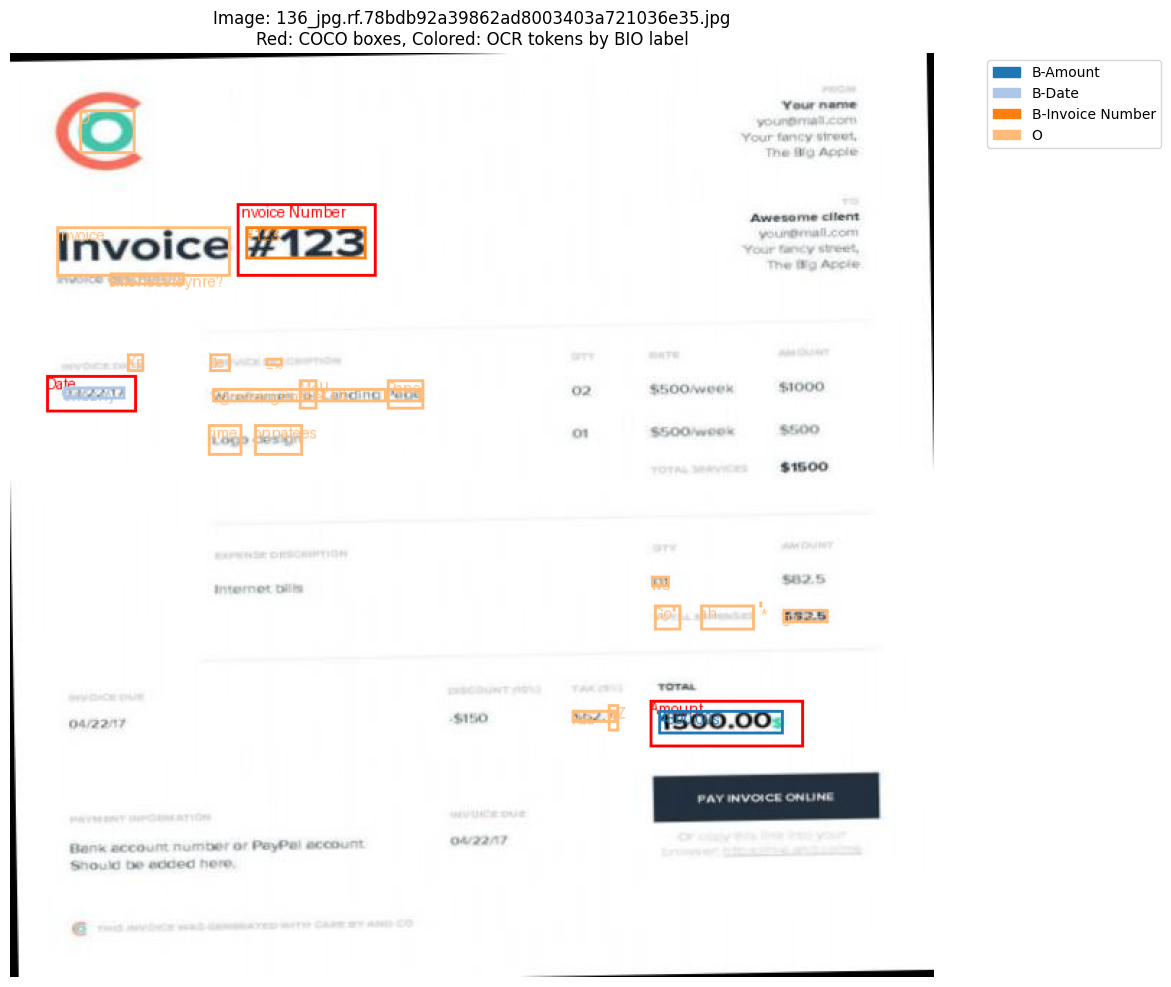

In [32]:
import os
import json
import random
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# --- CONFIGURATION ---
train_img_dir = "../dataset/train"
coco_ann_path = "../dataset/train/_annotations.coco.json"
jsonl_path = "../layoutlmv3_train.jsonl"

# --- LOAD COCO ANNOTATIONS ---
with open(coco_ann_path, "r", encoding="utf-8") as f:
    coco = json.load(f)
img_id_to_filename = {img["id"]: img["file_name"] for img in coco["images"]}
filename_to_img_id = {v: k for k, v in img_id_to_filename.items()}
img_id_to_anns = {}
for ann in coco["annotations"]:
    img_id_to_anns.setdefault(ann["image_id"], []).append(ann)
cat_id_to_name = {cat["id"]: cat["name"] for cat in coco["categories"]}

# --- LOAD JSONL (OCR tokens and BIO labels) ---
with open(jsonl_path, "r", encoding="utf-8") as f:
    jsonl_examples = [json.loads(line) for line in f]

# --- PICK RANDOM EXAMPLE ---
example = random.choice(jsonl_examples)
img_filename = example["file_name"] if "file_name" in example else example.get("image_path", None)
if img_filename is None:
    # Try to infer from tokens or fallback
    img_filename = os.path.basename(example["image"]) if "image" in example else None
assert img_filename is not None, "Could not determine image filename from JSONL example."

img_path = os.path.join(train_img_dir, img_filename)
img_id = filename_to_img_id.get(img_filename)
assert img_id is not None, f"Image id not found for {img_filename}"

# --- LOAD IMAGE ---
image = Image.open(img_path).convert("RGB")
draw = ImageDraw.Draw(image)

# --- PLOT COCO ANNOTATION BOXES ---
anns = img_id_to_anns.get(img_id, [])
for ann in anns:
    x, y, w, h = ann["bbox"]
    rect = [x, y, x + w, y + h]
    draw.rectangle(rect, outline="red", width=2)
    cat_name = cat_id_to_name.get(ann["category_id"], "unknown")
    draw.text((x, y), cat_name, fill="red")

# --- PLOT OCR TOKENS COLORED BY BIO LABEL ---
tokens = example["tokens"]
bboxes = example["bboxes"]
labels = example["labels"]

# Define a color map for BIO labels
import matplotlib
unique_labels = sorted(set(labels))
label_colors = {l: matplotlib.colors.to_hex(plt.cm.tab20(i % 20)) for i, l in enumerate(unique_labels)}

for token, bbox, label in zip(tokens, bboxes, labels):
    # bbox is [x0, y0, x1, y1] in 0-1000 normalized coordinates
    x0, y0, x1, y1 = [int(v * image.width / 1000) if i % 2 == 0 else int(v * image.height / 1000) for i, v in enumerate(bbox)]
    color = label_colors[label]
    draw.rectangle([x0, y0, x1, y1], outline=color, width=2)
    draw.text((x0, y0), token, fill=color)

# --- SHOW LEGEND ---
plt.figure(figsize=(12, 12))
plt.imshow(image)
legend_patches = [patches.Patch(color=label_colors[l], label=l) for l in unique_labels]
plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.axis('off')
plt.title(f"Image: {img_filename}\nRed: COCO boxes, Colored: OCR tokens by BIO label")
plt.show()

C:\Users\Haythem\AppData\Local\Temp\ipykernel_21520\435133269.py:95: UserWarning: Glyph 128997 (\N{LARGE RED SQUARE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Haythem\AppData\Local\Temp\ipykernel_21520\435133269.py:95: UserWarning: Glyph 127912 (\N{ARTIST PALETTE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


⚠️  Missed regions in annotation:
  - Amount


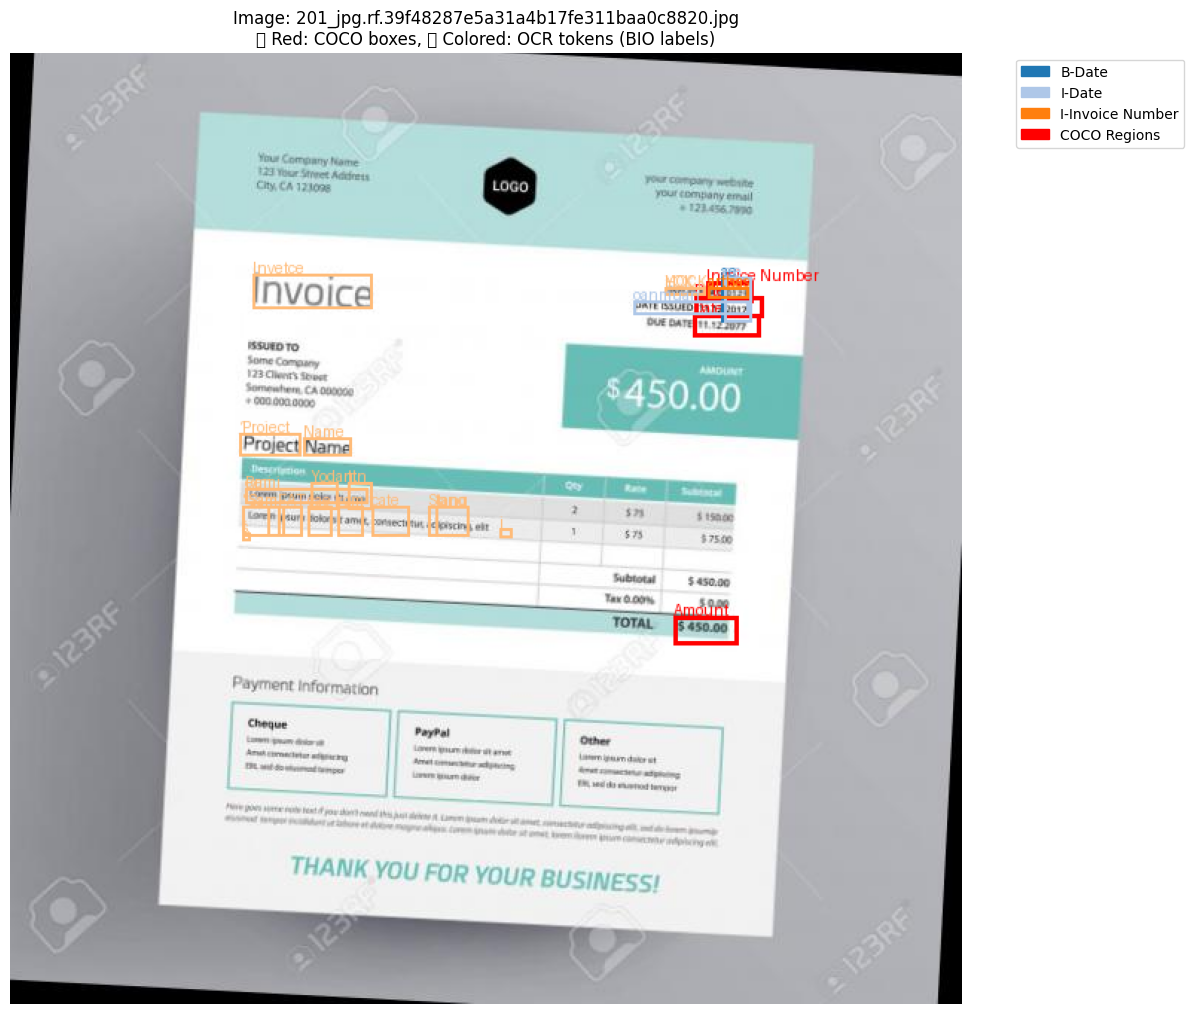

In [48]:
import os
import json
import random
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mcolors

from collections import defaultdict

# --- CONFIGURATION ---
train_img_dir = "../dataset/train"
coco_ann_path = "../dataset/train/_annotations.coco.json"
jsonl_path = "../layoutlmv3_train.jsonl"

# --- LOAD COCO ANNOTATIONS ---
with open(coco_ann_path, "r", encoding="utf-8") as f:
    coco = json.load(f)
img_id_to_filename = {img["id"]: img["file_name"] for img in coco["images"]}
filename_to_img_id = {v: k for k, v in img_id_to_filename.items()}
img_id_to_anns = defaultdict(list)
for ann in coco["annotations"]:
    img_id_to_anns[ann["image_id"]].append(ann)
cat_id_to_name = {cat["id"]: cat["name"] for cat in coco["categories"]}

# --- LOAD JSONL (OCR tokens and BIO labels) ---
with open(jsonl_path, "r", encoding="utf-8") as f:
    jsonl_examples = [json.loads(line) for line in f]

# --- PICK RANDOM EXAMPLE ---
example = random.choice(jsonl_examples)
img_filename = example.get("file_name") or example.get("image_path")
assert img_filename is not None, "Could not determine image filename from JSONL example."
img_path = os.path.join(train_img_dir, img_filename)
img_id = filename_to_img_id.get(img_filename)
assert img_id is not None, f"Image ID not found for {img_filename}"

# --- LOAD IMAGE ---
image = Image.open(img_path).convert("RGB")
draw = ImageDraw.Draw(image)

# --- PLOT COCO ANNOTATION BOXES ---
anns = img_id_to_anns.get(img_id, [])
missed_categories = set(cat_id_to_name[ann["category_id"]] for ann in anns)

for ann in anns:
    x, y, w, h = ann["bbox"]
    rect = [x, y, x + w, y + h]
    draw.rectangle(rect, outline="red", width=3)
    cat_name = cat_id_to_name.get(ann["category_id"], "unknown")
    draw.text((x, y - 10), cat_name, fill="red")

# --- PLOT OCR TOKENS COLORED BY BIO LABEL ---
tokens = example["tokens"]
bboxes = example["bboxes"]
labels = example["labels"]

# Build label-to-color mapping
unique_labels = sorted(set(labels))
label_colors = {l: mcolors.to_hex(plt.cm.tab20(i % 20)) for i, l in enumerate(unique_labels)}

# Denormalize helper
def denorm_bbox(norm_bbox, img_w, img_h):
    return [
        int(norm_bbox[0] * img_w / 1000),
        int(norm_bbox[1] * img_h / 1000),
        int(norm_bbox[2] * img_w / 1000),
        int(norm_bbox[3] * img_h / 1000)
    ]

# Track which categories were detected in labels
seen_categories = set()

for token, bbox, label in zip(tokens, bboxes, labels):
    x0, y0, x1, y1 = denorm_bbox(bbox, image.width, image.height)
    color = label_colors[label]
    draw.rectangle([x0, y0, x1, y1], outline=color, width=2)
    draw.text((x0, y0 - 10), token, fill=color)

    if label.startswith("B-") or label.startswith("I-"):
        seen_categories.add(label.split("-")[1])

# Check for missed regions
missed = missed_categories - seen_categories

# --- DISPLAY IMAGE WITH LEGEND ---
plt.figure(figsize=(12, 12))
plt.imshow(image)
legend_items = [patches.Patch(color=label_colors[l], label=l) for l in unique_labels if l != "O"]
legend_items.append(patches.Patch(color="red", label="COCO Regions"))

plt.legend(handles=legend_items, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title(f"Image: {img_filename}\n🟥 Red: COCO boxes, 🎨 Colored: OCR tokens (BIO labels)")
plt.axis("off")
plt.tight_layout()

if missed:
    print("⚠️  Missed regions in annotation:")
    for m in missed:
        print(f"  - {m}")

plt.show()


In [49]:
from collections import defaultdict, Counter

def compute_annotation_coverage(jsonl_path, coco_path):
    with open(jsonl_path, "r", encoding="utf-8") as f:
        jsonl_examples = [json.loads(line) for line in f]

    with open(coco_path, "r", encoding="utf-8") as f:
        coco = json.load(f)

    img_id_to_anns = defaultdict(list)
    for ann in coco["annotations"]:
        img_id_to_anns[ann["image_id"]].append(ann)

    filename_to_img_id = {img["file_name"]: img["id"] for img in coco["images"]}
    cat_id_to_name = {cat["id"]: cat["name"] for cat in coco["categories"]}

    print("Coverage Report")
    print("="*60)
    for ex in jsonl_examples:
        fname = ex["file_name"]
        tokens = ex["tokens"]
        labels = ex["labels"]
        tagged_tokens = [l for l in labels if l != "O"]
        tag_counts = Counter([l.split("-")[-1] for l in tagged_tokens if "-" in l])
        img_id = filename_to_img_id[fname]
        anns = img_id_to_anns.get(img_id, [])
        coco_labels = [cat_id_to_name[a["category_id"]] for a in anns]
        missed = set(coco_labels) - set(tag_counts.keys())
        print(f"Image: {fname}")
        print(f"  - COCO regions: {len(coco_labels)} → {Counter(coco_labels)}")
        print(f"  - Tagged tokens: {len(tagged_tokens)} → {tag_counts}")
        if missed:
            print(f"  🔴 Missed categories: {missed}")
        print()

compute_annotation_coverage(
    jsonl_path="../layoutlmv3_train.jsonl",
    coco_path="../dataset/train/_annotations.coco.json"
)

Coverage Report
Image: 219_jpg.rf.f5d1587c6b4d3417f86eb1588623e817.jpg
  - COCO regions: 3 → Counter({'Invoice Number': 1, 'Date': 1, 'Amount': 1})
  - Tagged tokens: 0 → Counter()
  🔴 Missed categories: {'Amount', 'Date', 'Invoice Number'}

Image: 105_jpg.rf.fb1226959cd48b65c04fe8e7e04990a7.jpg
  - COCO regions: 3 → Counter({'Invoice Number': 1, 'Date': 1, 'Amount': 1})
  - Tagged tokens: 2 → Counter({'Amount': 2})
  🔴 Missed categories: {'Date', 'Invoice Number'}

Image: 156_jpg.rf.fec69d73caaaf2750050e9806369cad0.jpg
  - COCO regions: 3 → Counter({'Invoice Number': 1, 'Date': 1, 'Amount': 1})
  - Tagged tokens: 4 → Counter({'Date': 3, 'Invoice Number': 1})
  🔴 Missed categories: {'Amount'}

Image: 166_jpg.rf.feeb4f228f0ddf822f378a05f729f900.jpg
  - COCO regions: 3 → Counter({'Invoice Number': 1, 'Date': 1, 'Amount': 1})
  - Tagged tokens: 1 → Counter({'Date': 1})
  🔴 Missed categories: {'Amount', 'Invoice Number'}

Image: 118_jpg.rf.f5df35eabe52612a78c8864a8d198d0d.jpg
  - COCO regi

In [ ]:
def check_token_overlap_with_regions(example, coco_ann_dict, coco_cat_dict):
    """
    For a given JSONL example, check how many tokens overlap each region (COCO box).
    Useful for debugging poor BIO tagging.
    """
    from shapely.geometry import box as shapely_box

    tokens = example["tokens"]
    bboxes = example["bboxes"]
    labels = example["labels"]
    fname = example["file_name"]

    img_id = filename_to_img_id[fname]
    anns = coco_ann_dict.get(img_id, [])

    print(f"Checking overlaps in: {fname}")
    for ann in anns:
        cat = coco_cat_dict[ann["category_id"]]
        x, y, w, h = ann["bbox"]
        region_box = shapely_box(x, y, x + w, y + h)
        count = 0
        inside_tokens = []
        for tok, norm_bbox, label in zip(tokens, bboxes, labels):
            # Denormalize to pixel space (assuming image size is known)
            x0 = int(norm_bbox[0] * 1)  # leave as-is (already normalized)
            y0 = int(norm_bbox[1] * 1)
            x1 = int(norm_bbox[2] * 1)
            y1 = int(norm_bbox[3] * 1)
            token_box = shapely_box(x0, y0, x1, y1)

            if region_box.intersects(token_box):
                count += 1
                inside_tokens.append((tok, label))

        print(f"  - Region '{cat}' → {count} token(s)")
        if count > 0:
            for tok, lbl in inside_tokens:
                print(f"     ↪ {tok} [{lbl}]")
        else:
            print("     🔴 No overlapping tokens found!")
    print()

check_token_overlap_with_regions(
    example=random.choice(jsonl_examples),
    coco_ann_dict=img_id_to_anns,
    coco_cat_dict=cat_id_to_name
)